In [37]:
#library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score,f1_score, make_scorer,roc_curve, auc, accuracy_score


from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import KMeansSMOTE
from sklearn.inspection import permutation_importance


In [18]:
df = pd.read_csv('hotel_bookings_processed.csv')
df

,is_canceled,lead_time,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_members,total_stay,continent,assignment
0,0,6,27,HB,Offline TA/TO,TA/TO,0,0,0,A,...,No Deposit,0,Transient,0.00,0,0,1.0,2,Europe,1
1,1,88,27,BB,Online TA,TA/TO,0,0,0,A,...,No Deposit,0,Transient,76.50,0,1,2.0,4,Europe,1
2,1,65,27,BB,Online TA,TA/TO,0,0,0,A,...,No Deposit,0,Transient,68.00,0,1,1.0,4,Europe,1
3,1,92,27,BB,Online TA,TA/TO,0,0,0,A,...,No Deposit,0,Transient,76.50,0,2,2.0,6,Europe,1
4,1,100,27,BB,Online TA,TA/TO,0,0,0,A,...,No Deposit,0,Transient,76.50,0,1,2.0,2,Europe,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53419,0,23,35,BB,Offline TA/TO,TA/TO,0,0,0,A,...,No Deposit,0,Transient,96.14,0,0,2.0,7,Europe,1
53420,0,102,35,BB,Online TA,TA/TO,0,0,0,E,...,No Deposit,0,Transient,225.43,0,2,3.0,7,Europe,1
53421,0,34,35,BB,Online TA,TA/TO,0,0,0,D,...,No Deposit,0,Transient,157.71,0,4,2.0,7,Europe,1
53422,0,109,35,BB,Online TA,TA/TO,0,0,0,A,...,No Deposit,0,Transient,104.40,0,0,2.0,7,Europe,1


In [19]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_week_number', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_members', 'total_stay', 'continent', 'assignment'],
      dtype='object')

## Scaling & Label Encoding

In [20]:
#Drop DV, train test split
X = df.drop(columns='is_canceled')
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
#Encode categorial columns - 11 columns 
label_encoder = preprocessing.LabelEncoder()
cols = ['meal','continent','market_segment','distribution_channel','is_repeated_guest',
        'reserved_room_type','assigned_room_type','deposit_type','customer_type','assignment','arrival_date_week_number']

X_train[cols] = X_train[cols].apply(label_encoder.fit_transform)#astype('category')
X_test[cols] = X_test[cols].apply(label_encoder.fit_transform)#astype('category')
#use label encoder - less dimension

In [22]:
#scale continuous columns - 10 columns
ss = StandardScaler()

columns_to_scale = ['previous_cancellations','previous_bookings_not_canceled','lead_time',
                    'days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests',
                    'total_members','total_stay','booking_changes']


# fit the scaler on the selected columns
ss.fit(X_train[columns_to_scale])

# transform the selected columns using the scaler
X_train[columns_to_scale] = ss.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = ss.transform(X_test[columns_to_scale])


In [21]:
#balance the dataset
#from sklearn.impute import SimpleImputer

#imputer = SimpleImputer(strategy='most_frequent')
#X_imputed = imputer.fit_transform(X_train)

#temp_X_train = pd.DataFrame(X_imputed, columns=X_train.columns)


#smote_tomek = SMOTETomek(random_state=901)

#X_train_resampled, y_train_resampled = smote_tomek.fit_resample(temp_X_train,y_train)


In [23]:
#balance the dataset
smote_tomek = SMOTETomek(random_state=901)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train,y_train)

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc

params_lr = {
    'C': uniform(loc=0, scale=5),
    'penalty': ['l2'],
    'max_iter': [1500],
    'random_state':[109]
}

randomCV = RandomizedSearchCV(LogisticRegression(), param_distributions=params_lr, scoring='recall',n_iter=30)
randomCV.fit(X_train_resampled, y_train_resampled)
print(randomCV.best_params_)

{'C': 1.8684853292731924, 'max_iter': 1500, 'penalty': 'l2', 'random_state': 109}


In [25]:
LR_best=LogisticRegression(C=1.8684853292731924,penalty='l2',max_iter=1500, random_state=109)
LR_best.fit(X_train_resampled,y_train_resampled)
y_pred_LR_best=LR_best.predict(X_test)


f1_score_LR_best = f1_score(y_test, y_pred_LR_best)
accuracy_LR_best = accuracy_score(y_test, y_pred_LR_best)
precision_LR_best = precision_score(y_test, y_pred_LR_best)
recall_LR_best = recall_score(y_test, y_pred_LR_best)

print('best LR f1_score:', f1_score_LR_best)

best LR f1_score: 0.590982087708462


### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

params_rf = {
    'n_estimators': randint(75, 200),
    'max_features': ["sqrt", "log2"],
    'random_state':[109],
    'min_samples_split': randint(2, 10)
}

randomisedForest = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params_rf, scoring='recall',n_iter=30)
randomisedForest.fit(X_train_resampled, y_train_resampled)
print(randomisedForest.best_params_)

{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 131, 'random_state': 109}


In [27]:
rf = RandomForestClassifier(min_samples_split=2,n_estimators=131, max_features='sqrt', random_state=109) 
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)


f1_score_RF_best = f1_score(y_test, y_pred_rf)
accuracy_RF_best = accuracy_score(y_test, y_pred_rf)
precision_RF_best = precision_score(y_test, y_pred_rf)
recall_RF_best = recall_score(y_test, y_pred_rf)
print('best RF f1_score:', f1_score_RF_best)

best RF f1_score: 0.656564045302281


### XGradient Boost

In [28]:
params_xgb = {
    'learning_rate': uniform(0.01, 0.1),
    'random_state':[109],
    'tree_method':['approx','hist','gpu_hist']
}


xgb_par = RandomizedSearchCV(XGBClassifier(), params_xgb, cv=5, verbose=0, scoring='recall',n_iter=30)
xgb_par.fit(X_train_resampled, y_train_resampled)
print(xgb_par.best_params_)

{'learning_rate': 0.10260546707053247, 'random_state': 109, 'tree_method': 'approx'}


In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    tree_method='approx', 
    random_state=109, 
    learning_rate=0.10260546707053247, 
    n_estimators=250, 
    max_depth=5, 
    enable_categorical=True
)


xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)

f1_score_XGB_best = f1_score(y_test, y_pred_xgb)
accuracy_XGB_best = accuracy_score(y_test, y_pred_xgb)
precision_XGB_best = precision_score(y_test, y_pred_xgb)
recall_XGB_best = recall_score(y_test, y_pred_xgb)
print('best XGB f1_score:', f1_score_XGB_best)

best XGB f1_score: 0.6517038007863697


In [30]:
model1 = {'name':'Logistic Regression','f1_score': f1_score_LR_best, 'accuracy': accuracy_LR_best, 'precision':precision_LR_best, 'recall':recall_LR_best}
model2 = {'name':'Random Forest','f1_score': f1_score_RF_best, 'accuracy': accuracy_RF_best, 'precision':precision_RF_best, 'recall':recall_RF_best}
model3 = {'name':'XGradient Boost','f1_score': f1_score_XGB_best, 'accuracy': accuracy_XGB_best, 'precision':precision_XGB_best, 'recall':recall_XGB_best}

In [31]:
model_data_list = [model1, model2, model3]
summary = pd.DataFrame(model_data_list, columns=['name','f1_score', 'accuracy', 'precision', 'recall'])
summary

,name,f1_score,accuracy,precision,recall
0,Logistic Regression,0.590982,0.690126,0.492789,0.738044
1,Random Forest,0.656564,0.798503,0.679657,0.634989
2,XGradient Boost,0.651704,0.801029,0.694726,0.613699


### Final Classification Model

In [32]:
selected_model = LR_best
y_pred_selected = y_pred_LR_best

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix=confusion_matrix(y_test,y_pred_selected)
confusion_matrix

array([[4982, 2462],
       [ 849, 2392]], dtype=int64)

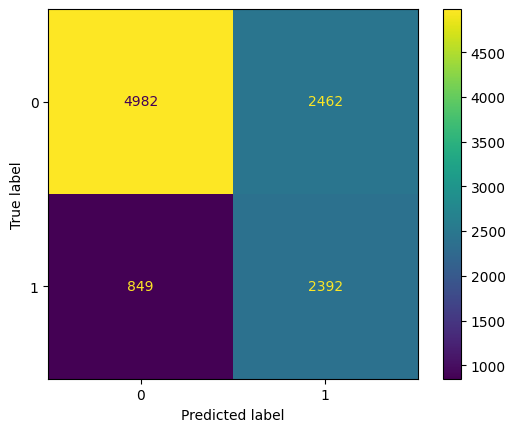

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()

In [39]:
adr_ave = df['adr'].mean()
nights_ave = df['total_stay'].mean()
rev_ave = adr_ave * nights_ave
print('Estimated loss in revenue from a vacant room due to cancellation: ${0}'.format(round(rev_ave,-1)))

Estimated loss in revenue from a vacant room due to cancellation: $350.0


In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#helper function that takes in a value structure and confusion matrix to find its value
def value_calculation(value_structure,cm):
    True_Negative=cm[0][0]*value_structure[0]
    False_Positive=cm[0][1]*value_structure[1]
    False_Negative=cm[1][0]*value_structure[2]
    True_Positive=cm[1][1]*value_structure[3]
    value=True_Negative+False_Positive+False_Negative+True_Positive
    return value

value_structure=[0,175,350,0]
value=[]
for i in range(0,101,10):
    threshold=i/100
    predict= (selected_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
    c_matrix=confusion_matrix(y_test,predict)
    value.append(value_calculation(value_structure,c_matrix))

list(zip(range(0,101,10),value))

[(0, 1302700),
 (10, 1116325),
 (20, 1008700),
 (30, 917350),
 (40, 809725),
 (50, 728000),
 (60, 690550),
 (70, 781200),
 (80, 953225),
 (90, 1061725),
 (100, 1134350)]

In [42]:
def value_plot(value_structure):
    value=[]
    for i in range(0,101,1):
        threshold=i/100
        predict= (selected_model.predict_proba(X_test)[:, 1] > threshold).astype('float')
        c_matrix=confusion_matrix(y_test,predict)
        value.append(value_calculation(value_structure,c_matrix))
    plt.figure(figsize=(15,8))
    plt.xlabel("Threshold")
    plt.ylabel("Total Estimated Loss")
    x_axis = range(0,101,1)
    y_axis = value
    return (plt.plot(x_axis,y_axis))

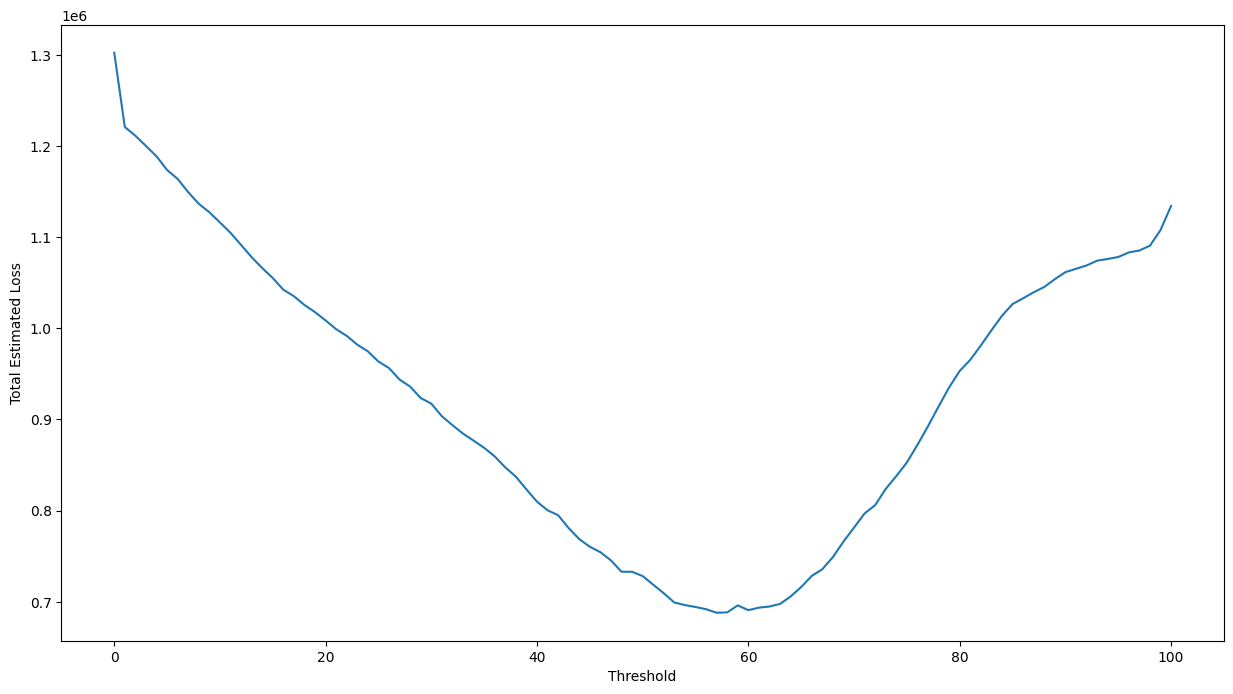

In [43]:
value_plot([0,175,350,0])

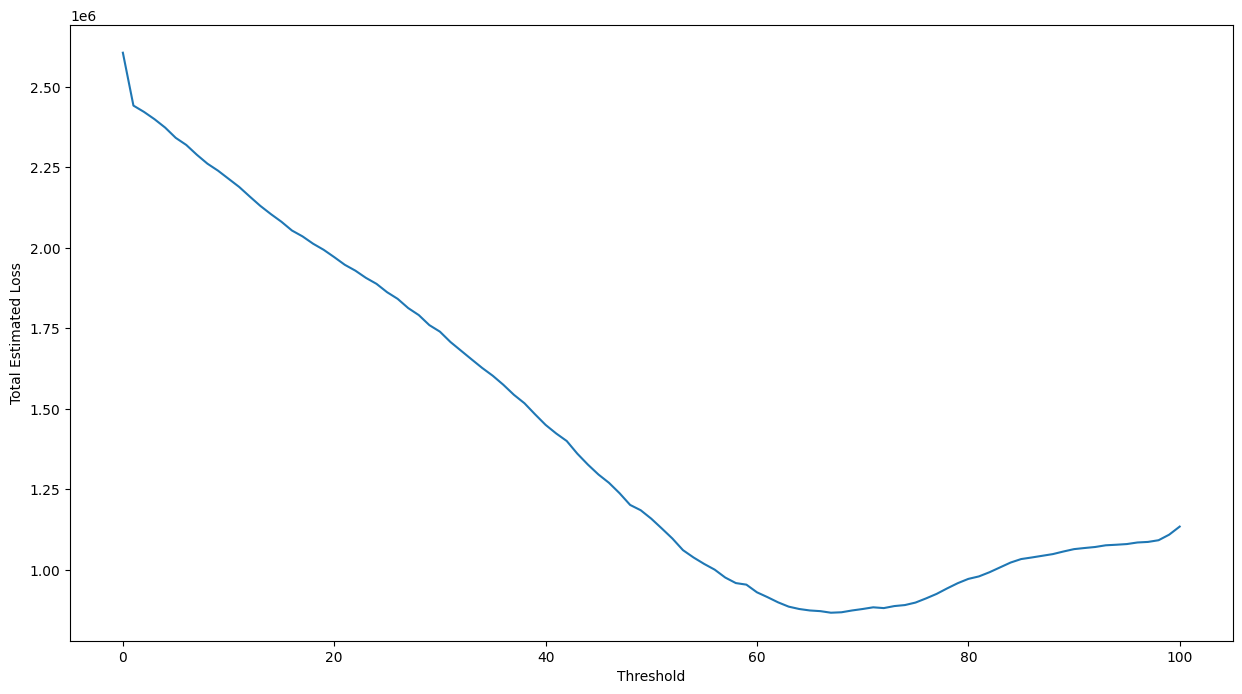

In [44]:
value_plot([0,350,350,0])